### Performing Binary Classification here.

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold,\
        cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('tcs_interviews_clean.json')

In [3]:
df.head()

,date,text,offer_tag,exp_tag,level_tag,sentiment
0,2023-04-27,I had 3 rounds of interview the process was ve...,Accepted Offer,Positive Experience,Average Interview,positive
1,2023-04-27,Had a nice experience in interview. Interviewe...,Accepted Offer,Positive Experience,Average Interview,positive
2,2023-04-26,It was an walk in drive in Bengaluru. They are...,No Offer,Positive Experience,Average Interview,neutral
3,2023-04-26,This was an on-campus internship opportunity. ...,No Offer,Positive Experience,Average Interview,neutral
4,2023-04-26,I recently interviewed for a software engineer...,Declined Offer,Positive Experience,Average Interview,positive


In [5]:
import gensim.downloader as api
# Load the pre-trained Word2Vec model
word_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [49]:
import numpy as np
import nltk
from sklearn.preprocessing import LabelEncoder


def convert_to_numeric(df, cat_cols=['exp_tag','level_tag','sentiment']):
    '''
    Converts categorical columns into numerical columns by using Label Encoder.
    
    '''

    num_df = df.loc[:,:]
    
    # encode categorical variables
    encoder = LabelEncoder()
    for col in cat_cols:
        num_df[col] = encoder.fit_transform(num_df[col])

    num_df['week_number'] = num_df.date.dt.week
    
    return num_df


def word_embedding(df, word_model):
    '''
    Convert text column using word embedding.
    '''
    model = word_model
    
    # Split the data into text and numerical features
    text_features = ['text'] 
    num_features = ['week_number','exp_tag','level_tag','sentiment']
    
    df['text'] = df['text'].apply(lambda x: x.lower() if isinstance(x, str) else x)
    X_text = df['text'].values.tolist()

    num_df = convert_to_numeric(df)
    X_num = num_df[num_features].values.astype(float) 

    # Convert the text data to a matrix of word embeddings
    X_emb = np.zeros(((len(X_text)), model.vector_size))
    for i, text in enumerate(X_text):
        words = nltk.word_tokenize(text)
        n_words = len(words)

        for word in words:
            if word in model.key_to_index:
                X_emb[i] += model[word]
        X_emb[i] /= len(words)


    # Combine the word embeddings and numerical features
    final_df = np.hstack((X_emb, X_num))
    
    final_df = pd.DataFrame(final_df)
    final_df.json('tcs_interviews_embedded.json')

    return final_df


In [51]:
num_df = word_embedding(df, word_model)
# num_df = pd.csv('tcs_interviews_embedded.csv')
y
num_df.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,0.019341,0.054074,-0.012604,0.025262,-0.037523,-0.016352,0.031907,-0.080934,0.041269,0.059021,...,-0.047158,0.027246,-0.006235,-0.008864,-0.001546,-0.008393,17.0,2.0,0.0,2.0
1,0.038391,0.035093,0.019545,0.076247,-0.027285,0.048614,0.017824,-0.057287,0.058668,0.071770,...,-0.046438,-0.012993,0.014942,-0.051896,0.005343,-0.019060,17.0,2.0,0.0,2.0
2,0.021045,-0.011653,-0.002315,0.060425,-0.041009,-0.031516,0.003201,-0.069079,0.028992,0.042411,...,0.022385,0.047307,0.008924,-0.059210,-0.009727,-0.021606,17.0,2.0,0.0,1.0
3,-0.007510,0.037825,0.021549,0.062492,-0.017574,-0.033392,0.010293,-0.060444,0.040503,0.038927,...,-0.018809,0.007826,-0.003556,-0.039822,0.007992,-0.030467,17.0,2.0,0.0,1.0
4,-0.013683,0.012319,0.022256,0.033632,-0.028783,0.001895,0.019214,-0.045545,0.035879,0.021430,...,-0.026411,0.009732,-0.008586,-0.027389,-0.013392,-0.028627,17.0,2.0,0.0,2.0


### Check Relationship between date and offer 

<AxesSubplot:xlabel='offer_tag', ylabel='date'>

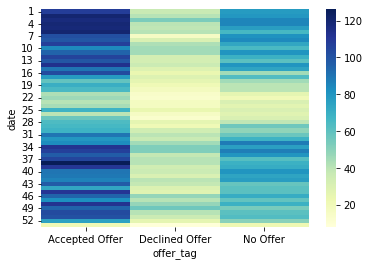

In [41]:
contingency_table = pd.crosstab(df['date'].dt.week, df['offer_tag'])
sns.heatmap(contingency_table, cmap='YlGnBu')
# contingency_table

### Inference for above heatmap
* From the patterns observed, it seems that there is a trend where __more offers were given in the earlier weeks of the year__, and the number of __offers__ given __decreased towards week 22.__
* This could suggest that the recruitment process may have been more active or successful in the earlier part of the year, or there may have been other factors that influenced the number of offers given to candidates.

In [54]:
# Creating X & y

# create mapping dictionary
offer_map = {'Accepted Offer': 1, 'No Offer': 0, 'Declined Offer': 1}

X = num_df
y = df['offer_tag'].map(offer_map)

y.to_csv('labels.csv')

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Check class balance

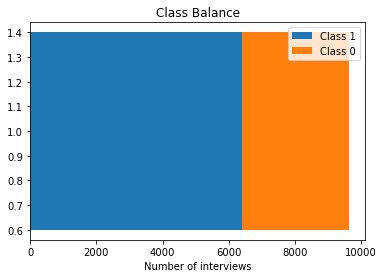

In [60]:
class_count = y.value_counts()

# create horizontal stacked bar chart
plt.barh(class_count.index[0], class_count[1], label='Class 1')
plt.barh(class_count.index[0], class_count[0], left=class_count[1], label='Class 0')

# set chart title and axis labels
plt.title('Class Balance')
plt.xlabel('Number of interviews')
plt.legend()

# display the chart
plt.show()


* There are 9636 total samples in the dataset.
* __Class 1__ has a count of 6410 samples, which represents approximately __66.5%__ of the total samples.
* __Class 0__ has a count of 3226 samples, which represents approximately __33.5%__ of the total samples.

### Handling skewed Class balance

* SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in a binary classification problem

Without SMOTE

In [ ]:
# Import necessary libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_dim=X_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

    ])
# Define optimizer with custom learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

# Train the neural network
model.fit(X_train, y_train, epochs=100,batch_size=256)

# Evaluate performance on test set
# Evaluate performance on test set
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'Test AUC: {auc}')

Test AUC is: 0.704

* We tried several algorithms including XGboost, SVM, and Neural Network. Neural network outperformed among all with test accuracy of __0.704__